In [1]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from colour import Color
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
from numpy.polynomial.polynomial import Polynomial
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import os
import sys
import time
import re
import random
import subprocess as S
import shutil #https://automatetheboringstuff.com/chapter9/
from decimal import Decimal
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# --------------------------------------
import requests
from datetime import datetime
import time
from io import StringIO
import kaleido
import pygame #To generate sounds in MAC

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Computer Modern Sans Serif']
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('grid', linestyle = '--', alpha = 0.2)     # grid
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pygame 2.5.2 (SDL 2.28.3, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


-------------------------------------------------------------------

# Essential Functions

In [4]:
def split_with_exception(case_name, exception_str):
    # Use a regular expression to split by '-' but ignore 'E-'
    parts = re.split(exception_str, case_name)
    return parts

def create_color_list(unique_values, palette):
# Create a color list
    cmap = plt.get_cmap(palette, len(unique_values))    # PiYG
    colors = []
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        colors.append(mpl.colors.rgb2hex(rgba))
    return colors

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

def fix_Crunch_exp_over100(s):
    #Funtion to deal with the exportation problem crunchflow has when dealing with exponents greather than E+99
    if s == 'NaN':
        pass
    else:
        if 'E' not in s:        
            cont_m = 0
            cont_p = 0
            for i in range(len(s)):
                if s[i] == '-': 
                    cont_m+=1
                elif s[i] == '+': 
                    cont_p+=1
            if cont_m == 2:
                exp_pos = s.rfind('-')-1
            elif cont_p == 2:
                exp_pos = s.rfind('+')-1
                print('double +')
            elif (cont_m == 1) & (cont_p == 1) & (s[0] == '-'):    
                exp_pos = s.rfind('+')-1
            else:
                exp_pos = s.rfind('-')-1
            s = s[0:exp_pos+1] +'E'+s[exp_pos+1:len(s)]
        else:
            s = s
    return(s)

cols = ['Depth_m', 'year', 'Na_mM', 'K_mM', 'Ca_mM', 'Mg_mM', 'Si_mM']
def build_VMS_df(chem_df, start_year):
    df_field = chem_df.loc[:,cols].dropna()
    df_field = df_field.loc[df_field.year >= start_year]
    df_field = df_field.drop(columns = 'year')
    df_field.columns = ['Distance', 'Na+', 'K+', 'Ca++', 'Mg++', 'SiO2(aq)']
    df_field = df_field.groupby('Distance').agg(['mean', 'std']).reset_index()
    
    return df_field

MWs = {'Na+':22.98,
         'K+':39,
         'Ca++':40.08,
         'Mg++':24.3,
         'SiO2(aq)': 28}

In [5]:
def compile_sim_output(working_folder, case_name):
    BK_names = []
    cont = 0

    for filename in os.listdir(os.path.join(working_folder, case_name)):
        if 'timeseries' in filename: 
            data_f = list()
            with open(os.path.join(working_folder, case_name, filename)) as fp: 
                for cnt, line in enumerate(fp):
                    if cnt == 1:
                        cols = line.strip().split()[0:17] #17
                        cols[0] = 'time'
                    elif cnt > 1:
                        data = line.strip().split()[0:17] #17
                        data = list(map(fix_Crunch_exp_over100, data))
                        data = list(map(float, data))
                        data_f.append(data)
            BK_df = pd.DataFrame(data_f, columns = cols)
    return BK_df

In [6]:
def compile_Crunch_output(output_name, host_folder, case):
    #function to compile all the output files of a sensibility in a dictionnary containing the different parameters
    cont = 0

    for filename in os.listdir(os.path.join(host_folder, case)):
        if output_name in filename:       
            with open(os.path.join(host_folder, case, filename)) as fp:
                data_f = pd.DataFrame()
                for cnt, line in enumerate(fp):
                    if cnt == 0: #Recover time value
                        time = float("{}".format(line.strip()).split()[2])  
                    if cnt == 2: #recover column name
                        cols = "{}".format(line.strip()).split() 
                        cols.insert(0, 'time')
                    if cnt >= 3: #recover field value
                        aux = list()
                        data = "{}".format(line.strip())
                        aux.append(time)
                        for i in data.split():
                            i = fix_Crunch_exp_over100(i)
                            aux.append(float(i))

                        aux = pd.DataFrame([aux], columns = cols)
                        if cnt == 3: 
                            data_f = aux.copy()
                        else:
                            data_f = pd.concat([data_f, aux])

    data_f = data_f.sort_values(by=['time', 'Distance']).reset_index(drop = True)
    data_f.insert(0, 'Case', case)

    return data_f

def build_output_df(working_folder, case_name):
    BK_names = []
    cont = 0

    for filename in os.listdir(os.path.join(working_folder, case_name)):
        if 'timeseries' in filename: 
            data_f = list()
            with open(os.path.join(working_folder, case_name, filename)) as fp: 
                for cnt, line in enumerate(fp):
                    if cnt == 1:
                        cols = line.strip().split()[0:17] #17
                        cols[0] = 'time'
                    elif cnt > 1:
                        data = line.strip().split()[0:17] #17
                        data = list(map(fix_Crunch_exp_over100, data))
                        data = list(map(float, data))
                        data_f.append(data)
            BK_df = pd.DataFrame(data_f, columns = cols)

    dfs_output = []
    aux_output = []
    outvars = ['conc', 'totcon', 'saturation', 'exchange', 'gases'] 
    for outvar in outvars:
        aux = compile_Crunch_output(outvar, working_folder, case_name)
        aux_output.append(aux)

    aux_output = dict(zip(outvars, aux_output)) # create dict of outputs for the case ---> outputvariable : df_output
             
    return BK_df, aux_output

In [7]:
def plot_sensitivity_results_Majors_mod(dfs_output, cases_list, df_vms):

    spes_with_field_obs = ['Ca++', 'Mg++', 'Na+', 'K+', 'SiO2(aq)']

    # Create subplots
    fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharex=False, sharey=True)
    legend_ax1 = fig.add_axes([0.62, 0.2, 0.35, 0.75], frame_on=False)  # Legend for cont == 6
    legend_ax2 = fig.add_axes([0.62, 0.1, 0.35, 0.25], frame_on=False)  # Legend for cont == 7
    legend_ax1.axis('off')  # Hide the external axis itself
    legend_ax2.axis('off')  # Hide the external axis itself

    colors = create_color_list(cases_list, 'tab20')[::-1]  # Reverse colors to match the cases

    for case_name, color_iter in zip(cases_list, colors):
        linestyle = ':' if 'No_Deep' in case_name else '-'
        legend_label = case_name

        # Loop over the species
        iter_cont = 0
        for cont, spe in enumerate(['Ca++', 'Mg++', 'Na+', 'K+', 'SiO2(aq)', 'Al+++', 'CO2(g)', 'O2(g)', 'pH']):
            row, col = divmod(cont, 3)  # Calculate row and column index for subplots
            ax = axs[row, col]

            if spe in ['CO2(g)', 'O2(g)']:  # Simulated Gases 
                df_t = dfs_output[case_name]['gases'].loc[dfs_output[case_name]['gases'].time == 50]
                ax.plot(df_t[spe] * 100 / 1.013, df_t['Distance'], label=legend_label, color=color_iter, linestyle=linestyle)
                ax.set_title(f'{spe} [%]')
                if spe == 'CO2(g)':
                    ax.text(x = 2, y = 9 , s = 'Field data \navailable in SI from \nTune et al., 2020', fontsize = 7)
                else:
                    ax.text(x = 10, y = 9 , s = 'Field data \navailable in SI from \nTune et al., 2020', fontsize = 7)

            elif spe == 'pH':  # Plot pH
                df_t = dfs_output[case_name]['conc'].loc[dfs_output[case_name]['conc'].time == 50]
                ax.plot(df_t[spe], df_t['Distance'], label=legend_label, color=color_iter, linestyle=linestyle)
                ax.set_title(spe)

            else:  # Other Species
                if iter_cont == 0 and spe in spes_with_field_obs:
                    ax.plot(df_vms[spe]['mean'], df_vms['Distance'], marker='o', linestyle='', color='grey')
                    ax.errorbar(df_vms[spe]['mean'], df_vms['Distance'], xerr=df_vms[spe]['std'], fmt='none', ecolor='black', capsize=5, alpha=0.1)
            
                df_t = dfs_output[case_name]['totcon'].loc[dfs_output[case_name]['totcon'].time == 50]
                ax.plot(df_t[spe] * 1000, df_t['Distance'], label=legend_label, color=color_iter, linestyle=linestyle)
                ax.set_title(f'{spe} [mM]')

            # Set common plot properties
            ax.set_ylim(18.9, -0.5)
            if spe == 'Na+':
                ax.set_xlim(1e-2, 1e0)
            elif spe == 'SiO2(aq)':
                ax.set_xlim(1e-2, 1e0)
            
            ax.set_xscale('log' if spe in ['Ca++', 'Mg++', 'Na+', 'K+', 'SiO2(aq)', 'Al+++'] else 'linear')
            ax.set_ylabel('Depth [m]' if col == 0 else '')

            # Handle legends for specific cases
            if cont == 6:
                handles, labels = ax.get_legend_handles_labels()
                legend_ax1.legend(handles, labels, loc=2, title=f'Simulation case:')
        iter_cont += 1
    
    plt.subplots_adjust(left=0.06, right=0.6, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)
    
    return fig

---------

# Batch experimental and modeling results

In [10]:
#Read batch experiments results
batch_exp_df = pd.read_csv('../HydroShare_repo/BatchExperimentCations.csv')

#Read batch modeling results
domains = ['Deep', 'Middle', 'Shallow']
Best_fits_dict = {'Shallow':'Shallow_Cuttings_batch',
                 'Middle':'Middle_Cuttings_batch',
                  'Deep':'Deep_Cuttings_batch'
                 }
working_folder = '../GitHub_Zenodo_repo/Batch_Experiments_Model/'

BK_dict = []
for domain in domains:
    case_name = Best_fits_dict[domain]
    BK_df = compile_sim_output(working_folder, case_name)
    BK_dict.append(BK_df)
BK_dict = dict(zip(domains, BK_dict))

Plot batch best fitting model along with experimental results

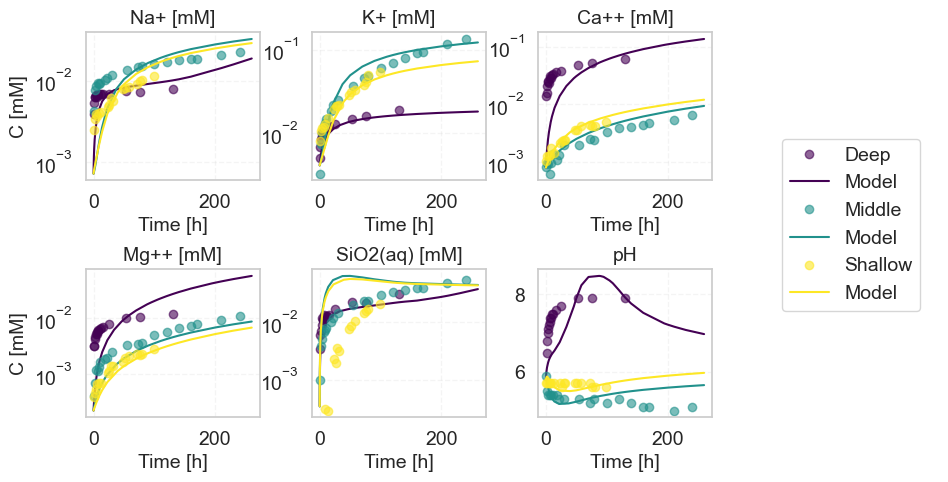

In [12]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(11, 5))
gs = GridSpec(2, 4, figure=fig, wspace=0.3, hspace=0.6)

axs = [fig.add_subplot(gs[i // 3, i % 3]) for i in range(6)]  
colors = create_color_list(domains, 'viridis')
spes = ['Na_mM', 'K_mM', 'Ca_mM', 'Mg_mM', 'Si_mM', 'pH']
labels = ['Na+', 'K+', 'Ca++', 'Mg++', 'SiO2(aq)', 'pH']

for spe, label, ax in zip(spes, labels, axs):
    for domain, color in zip(domains, colors):
        df_aux = BK_dict[domain]
        df_batch = batch_exp_df.loc[batch_exp_df.Group == domain]
        ax.plot(df_batch['Cum_hours'], df_batch[spe], marker='o', linestyle='', color=color, alpha=0.6, label=domain)
        if spe == 'pH':
            ax.plot(df_aux['time'], df_aux[spe], color=color, label='Model')
            ax.set(yscale='linear', title=spe, xlabel='Time [h]')
        else:
            ax.plot(df_aux['time'], df_aux[label] * 1000, color=color, label='Model')
            ax.set(yscale='log', title=f'{label} [mM]', xlabel='Time [h]')

axs[0].set_ylabel('C [mM]')
axs[3].set_ylabel('C [mM]')
ax_legend = fig.add_subplot(gs[:, 3]) 
ax_legend.axis('off')  

handles, labels = axs[0].get_legend_handles_labels()  
ax_legend.legend(handles, labels, loc='center')
plt.show()

# VMS field data

Compare data from VMS ports type A and B to show they are consistent

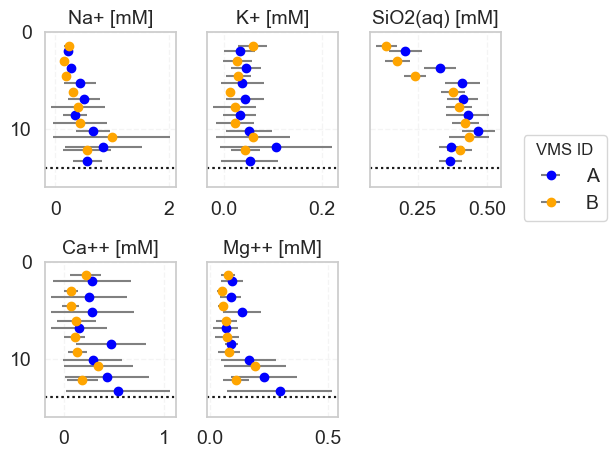

In [15]:
depth_watertable = 14 #meters
vms_field_df = pd.read_csv('../HydroShare_repo/CationsMaster.csv')

fig, axs = plt.subplots(2,3, sharey = True, sharex = False)
for VMS_choice, color in zip(['A', 'B'], ['blue', 'orange']):
    aux_chem = vms_field_df.loc[vms_field_df.port_ID.str.contains(VMS_choice)]
    df_aux = build_VMS_df(aux_chem, 2016)
    df_aux = df_aux.loc[df_aux.Distance < depth_watertable]
    for spe, colrow in zip(['Na+', 'K+', 'Ca++', 'Mg++', 'SiO2(aq)'], 
                      [[0,0], [0,1], [1,0], [1,1], [0,2]]):
        ax = axs[colrow[0], colrow[1]]
        ax.errorbar(x = df_aux[spe]['mean'], y = df_aux['Distance'], xerr = df_aux[spe]['std'],
                    fmt = 'o', ecolor = 'grey', label = VMS_choice, color = color)
        ax.set(title = f'{spe} [mM]', ylim = (16,0))
        ax.axhline(y = 14, linestyle = ':', color = 'k')
axs[1,2].set_axis_off()
ax.legend(bbox_to_anchor = (1.1,0.4), loc = 2, title = 'VMS ID')
fig.tight_layout()
plt.show()

Compute fluxes from VMS field data

Keep working only with A-type VMS ports and Remove outliers from dataset

In [247]:
variables = ['Ca_mM', 'Mg_mM', 'K_mM', 'Na_mM', 'Si_mM']
# Uniformize data
vms_field_df = vms_field_df.loc[vms_field_df.port_ID.str.contains('A')]
vms_field_df = vms_field_df.loc[:,['port_ID', 'Depth_m', 'Date', 'year', 'month']+variables]
vms_field_df = vms_field_df.loc[(vms_field_df.year < 2020)]

# Define variables of interest
variables = ['Ca_mM', 'Mg_mM', 'K_mM', 'Na_mM', 'Si_mM']

# Create an empty DataFrame to store cleaned data
vms_field_df_long = pd.DataFrame()

# Remove outliers for each variable and port ID
for spe in variables:
    for port_id in vms_field_df['port_ID'].unique():
        filtered_data = remove_outliers(
            vms_field_df.loc[vms_field_df['port_ID'] == port_id, ['port_ID', 'Depth_m', 'Date', 'year', 'month', spe]], 
            spe
        )
        filtered_data['spe'] = spe  # Add 'spe' column to indicate the variable
        filtered_data.columns = ['port_ID', 'Depth_m', 'Date', 'year', 'month', 'value', 'spe']
        vms_field_df_long = pd.concat([vms_field_df_long, filtered_data])

# Pivot the cleaned data
vms_field_df_short = vms_field_df_long.pivot_table(
    index=['port_ID', 'Depth_m', 'Date', 'year', 'month'],  
    columns='spe',  
    values='value',  
    aggfunc='first'  
).reset_index()

Compute chemical weathering fluxes from VMS data

In [249]:
start_year = 2016 
rain_source = 'RW'
Flow_std = 0.40 #m/yr from 2016-2020 weather data
Avg_F_CW_kim = 163.0 #ton/m2/yr --> this value is comparable with mine, from my excel file FluxesVerification.xlsx
Avg_F_creek_kim = 118.7
print(f'### Mass Fluxes from {start_year}-2020 ###\n---> (SiO2 as Si to compary with Kim) <---\n--------------')

Aqueous_input = pd.read_csv('../HydroShare_repo/RainfallChemistry.csv')

df_aux = build_VMS_df(vms_field_df_short, start_year)
df_aux = df_aux.loc[df_aux.Distance < depth_watertable]

Darcy_Flow = 1.7 #m/y Range computed from P-ET data
flux_Ca_field =((df_aux['Ca++'].iloc[-1]['mean']/1000- #mM to mol/L
                 float(Aqueous_input.loc[Aqueous_input.Var == 'Ca++', rain_source].values[0]))# mol/L
                 *40#g/mol -> atomic mass
                 *1000)# L/m3
flux_Mg_field = (df_aux['Mg++'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Mg++', rain_source].values[0]))*24.3*1000
flux_Na_field = (df_aux['Na+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Na+', rain_source].values[0]))*22.98*1000
flux_K_field = (df_aux['K+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'K+', rain_source].values[0]))*39.09*1000
flux_Si_field = (df_aux['SiO2(aq)'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'SiO2(aq)', rain_source].values[0]))*(28)*1000

Delta_C = 1000*((df_aux['Ca++'].iloc[-1]['mean']/1000-float(Aqueous_input.loc[Aqueous_input.Var == 'Ca++', rain_source].values[0]))*40 +\
            (df_aux['Mg++'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Mg++', rain_source].values[0]))*24.3 +\
            (df_aux['Na+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Na+', rain_source].values[0]))*22.98 +\
            (df_aux['K+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'K+', rain_source].values[0]))*39.09 +\
            (df_aux['SiO2(aq)'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'SiO2(aq)', rain_source].values[0]))*(28))


Std_sumC_field = np.sqrt(
                (df_aux['Ca++'].iloc[-1]['std']*40)**2 + 
                (df_aux['Mg++'].iloc[-1]['std']*24.3)**2 + 
                (df_aux['Na+'].iloc[-1]['std']*22.98)**2 +
                (df_aux['K+'].iloc[-1]['std']*39.09)**2 +
                (df_aux['SiO2(aq)'].iloc[-1]['std']*(28))**2)

sumC = flux_Ca_field + flux_Mg_field + flux_Na_field + flux_K_field + flux_Si_field
Flux_field = sumC * Darcy_Flow 
Std_Flux_field = Flux_field*np.sqrt((Std_sumC_field/sumC)**2+
                                   (Flow_std/Darcy_Flow)**2)
VZ_fraction_to_F_CW = 100*Flux_field/Avg_F_CW_kim
VZ_fraction_to_creek = 100*Flux_field/Avg_F_creek_kim
print(f'for A-type VMS ports & Drainage {Darcy_Flow} m/y:') 
print(f'Delta C = {Delta_C:.1f} mg\L')
print(f'total flux = {Flux_field:.1f} +/- {Std_Flux_field:.1f} g/m2/yr (or ton/km2/yr)')
print(f'VZ estimate represents {VZ_fraction_to_F_CW:.1f}% of the total chemical flux')
print(f'and represents {VZ_fraction_to_creek:.1f}% of the chemical flux in Elder Creek')

### Mass Fluxes from 2016-2020 ###
---> (SiO2 as Si to compary with Kim) <---
--------------
for A-type VMS ports & Drainage 1.7 m/y:
Delta C = 47.6 mg\L
total flux = 80.9 +/- 34.2 g/m2/yr (or ton/km2/yr)
VZ estimate represents 49.6% of the total chemical flux
and represents 68.1% of the chemical flux in Elder Creek


In [250]:
print('### How concentrations change in milliequivalents ###\n--------------')

df_aux = build_VMS_df(vms_field_df_short, 2016)
df_aux = df_aux.loc[df_aux.Distance < depth_watertable]

for loc, label in zip([0, -1], ['top', 'bottom']):
    total_conc = 0  # To accumulate total concentration at each location
    total_std = 0
    for spe, eq in zip(['Ca++', 'Mg++', 'Na+', 'K+', 'SiO2(aq)'], [2, 2, 1, 1, 1]):
        conc = df_aux[spe].iloc[loc]['mean'] * MWs[spe]   # mg/L
        std = df_aux[spe].iloc[loc]['std'] * MWs[spe]  # mg/L
        total_conc += conc
        total_std += std**2
        if spe == 'SiO2(aq)':
            print(f'{spe} at {label} = {conc:.1f} +- {std:.1f} mg/L\n')# meq/L\n')
        else:
            print(f'{spe} at {label} = {conc:.1f} +- {std:.1f} mg/L')# meq/L')

    total_std = np.sqrt(total_std)
    print(f'Total concentration at {label} of VMS = {total_conc:.1f} +- {total_std:.1f} mg/L\n')# meq/L\n')


### How concentrations change in milliequivalents ###
--------------
Ca++ at top = 4.5 +- 1.6 mg/L
Mg++ at top = 1.8 +- 0.3 mg/L
Na+ at top = 4.8 +- 0.9 mg/L
K+ at top = 1.0 +- 0.3 mg/L
SiO2(aq) at top = 5.3 +- 1.0 mg/L

Total concentration at top of VMS = 17.4 +- 2.1 mg/L

Ca++ at bottom = 19.2 +- 16.0 mg/L
Mg++ at bottom = 6.6 +- 4.1 mg/L
Na+ at bottom = 10.4 +- 2.5 mg/L
K+ at bottom = 1.5 +- 0.3 mg/L
SiO2(aq) at bottom = 10.2 +- 0.9 mg/L

Total concentration at bottom of VMS = 47.9 +- 16.7 mg/L



In [251]:
df_vms = build_VMS_df(vms_field_df_short, 2016)
df_vms = df_vms.loc[df_vms.Distance < depth_watertable]

total_rsd_list = []  # To store RSD values for all depths (YY%)
total_std_list = []  # To store weighted stddevs for all depths
depth_means = []     # To store weighted mean concentrations for each depth (for XX%)

for loc in df_vms.Distance.unique():
    print(f'*********** Working at depth = {loc}m ***********')

    means = []       # Store means of individual cations
    stds = []        # Store stddevs of individual cations
    weights = []     # Store normalized weights (based on variance)

    # Iterate over each cation and calculate weighted stats
    for spe, eq in zip(['Ca++', 'Mg++', 'Na+', 'K+', 'SiO2(aq)'], [2, 2, 1, 1, 1]):
        # Get mean and standard deviation and convert to mg/L using molecular weight
        conc_mean = df_vms.loc[df_vms.Distance == loc, spe]['mean'].values[0] * MWs[spe]
        conc_std = df_vms.loc[df_vms.Distance == loc, spe]['std'].values[0] * MWs[spe]

        # Append data
        means.append(conc_mean)
        stds.append(conc_std)

        # Calculate weight for the cation as 1/variance
        variance = conc_std ** 2
        if variance > 0:
            weights.append(1 / variance)
        else:
            weights.append(0)  # Avoid division by zero

    # Normalize weights so they sum to 1
    weights_sum = sum(weights)
    normalized_weights = [w / weights_sum for w in weights] if weights_sum > 0 else [0] * len(weights)

    # Calculate the weighted mean
    weighted_mean = sum(w * m for w, m in zip(normalized_weights, means))
    depth_means.append(weighted_mean)  # Store the weighted mean for this depth

    # Calculate the weighted variance
    weighted_variance = sum(w * (s ** 2) for w, s in zip(normalized_weights, stds))
    weighted_std = np.sqrt(weighted_variance)
    total_std_list.append(weighted_std)  # Store the weighted std for this depth

    print(f'\nWeighted mean at {loc} = {weighted_mean:.1f} mg/L')
    print(f'Weighted std at {loc} = {weighted_std:.1f} mg/L')

    # Append the weighted relative standard deviation (RSD) for this location
    if weighted_mean != 0:
        rsd = (weighted_std / weighted_mean) * 100
    else:
        rsd = 0  # Avoid division by zero

    total_rsd_list.append(rsd)
    print(f'Relative standard deviation (RSD) at {loc} = {rsd:.0f}%\n')

# Compute the average RSD across all depths (YY%)
if total_rsd_list:
    average_rsd = np.mean(total_rsd_list)
    print(f'\nAverage RSD for single depths (YY%) = {average_rsd:.0f}%')
else:
    print("\nNo valid data across all depths.")

# Compute the average std dev across all depths
if total_std_list:
    average_std = np.mean(total_std_list)
    print(f'\nAverage standard deviation (StdDev) across all depths = {average_std:.1f} mg/L')
else:
    print("\nNo valid standard deviations across all depths.")

# Compute the RSD of mean concentrations across depths (XX%)
if depth_means:
    overall_mean = np.mean(depth_means)
    overall_std = np.std(depth_means)
    if overall_mean != 0:
        xx_rsd = (overall_std / overall_mean) * 100
        print(f'\nRSD of mean concentrations across depths (XX%) = {xx_rsd:.0f}%')
    else:
        print("\nOverall mean concentration across depths is zero. Cannot compute XX%.")
else:
    print("\nNo valid mean concentrations across depths.")


*********** Working at depth = 1.95m ***********

Weighted mean at 1.95 = 1.8 mg/L
Weighted std at 1.95 = 0.5 mg/L
Relative standard deviation (RSD) at 1.95 = 26%

*********** Working at depth = 3.64m ***********

Weighted mean at 3.64 = 2.2 mg/L
Weighted std at 3.64 = 0.6 mg/L
Relative standard deviation (RSD) at 3.64 = 28%

*********** Working at depth = 5.22m ***********

Weighted mean at 5.22 = 1.6 mg/L
Weighted std at 5.22 = 0.5 mg/L
Relative standard deviation (RSD) at 5.22 = 29%

*********** Working at depth = 6.88m ***********

Weighted mean at 6.88 = 1.9 mg/L
Weighted std at 6.88 = 0.6 mg/L
Relative standard deviation (RSD) at 6.88 = 35%

*********** Working at depth = 8.49m ***********

Weighted mean at 8.49 = 1.5 mg/L
Weighted std at 8.49 = 0.4 mg/L
Relative standard deviation (RSD) at 8.49 = 29%

*********** Working at depth = 10.16m ***********

Weighted mean at 10.16 = 3.3 mg/L
Weighted std at 10.16 = 0.9 mg/L
Relative standard deviation (RSD) at 10.16 = 27%

*********** 

# 1D RTM for the VMS

## Figure 3 - BaseCase model

In [295]:
working_folder = '../GitHub_Zenodo_repo/1D_model/Figure3_simulations/'

BK_dict = []
dfs_output = []
simulation_cases = os.listdir(os.path.join(working_folder))
try:
    simulation_cases.remove('.DS_Store')
except:
    next
for case_name in simulation_cases:
    BK_df, output_df = build_output_df(working_folder, case_name)
    BK_dict.append(BK_df)
    dfs_output.append(output_df)
BK_dict = dict(zip(simulation_cases, BK_dict))
dfs_output = dict(zip(simulation_cases, dfs_output)) #create dictionnary of case : df_outputs   

index_above_watertable = (dfs_output['BaseCase']['conc'].Distance - depth_watertable).abs().idxmin()

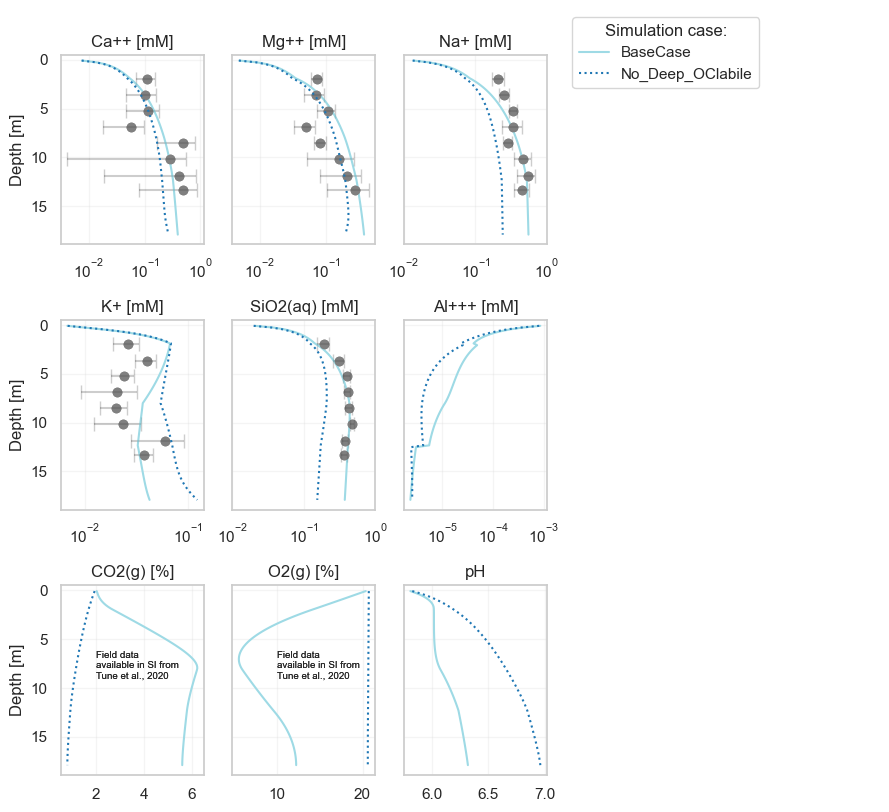

In [297]:
fig = plot_sensitivity_results_Majors_mod(dfs_output, simulation_cases, df_vms)
plt.show()

### Compute fluxes in Simulation

In [323]:
root = '../GitHub_Zenodo_repo/1D_model/Figure4_simulations/'
results = []
fluxes_df = pd.DataFrame()
for watsat in ['15', '23', '25', '30', '40', '50']:
    for BC, BC_value in zip(['4E-2', '17E-3', '23E-3', '1E-2', '2E-2'],
                           [4E-2, 1.7E-2, 2.3E-2, 1.2E-2, 2E-2]):
        BK_dict = []
        dfs_output = []
        working_folder = os.path.join(root, f'CoxNoCox_Sat_1R{watsat}_CO2_{BC}')        
        simulation_cases = os.listdir(os.path.join(working_folder))
        
        for case_name in simulation_cases:
            if os.path.isdir(os.path.join(working_folder, case_name)):
                BK_df, output_df = build_output_df(working_folder, case_name)
                BK_dict.append(BK_df)
                dfs_output.append(output_df)
        BK_dict = dict(zip(simulation_cases, BK_dict))
        dfs_output = dict(zip(simulation_cases, dfs_output)) #create dictionnary of case : df_outputs   
        
        np.sort(list(dfs_output.keys()))
        for Flow, Flow_value in zip(['5.0E-01', '6.0E-01', '7.0E-01', '8.0E-01', '1.0E+00', '1.1E+00', '1.2E+00', '1.3E+00', '1.5E+00', '1.7E+00', '2.0E+00', 
                                     '2.3E+00', '2.5E+00', '3.0E+00', '3.5E+00', '4.0E+00', '5.0E+00', '6.0E+00', '8.0E+00', '1.0E+01'], 
                                    [0.5, 0.6, 0.7, 0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.7, 2, 2.3, 2.5, 3, 3.5, 4, 5, 6, 8, 10]):

            cont =0
            total_flux = [0, 0]
            flux_Ca = [0, 0]
            flux_Mg = [0, 0]
            flux_Na = [0, 0]
            flux_K = [0, 0]
            flux_Si = [0, 0]
            flux_alkalinity = [0, 0]
            Darcy_Flow = Flow_value #m/y
                
            try: 
                for case_name, text in zip([f'WithDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}', 
                                        f'NoDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'], 
                                      ['WithDeepOClabile', 'NoDeepOClabile']):
                    df = dfs_output[case_name]['totcon']
                    df_alkalinity = dfs_output[case_name]['conc']
                    # print(f'Values with {text}:')
                    flux_Ca[cont]=((df['Ca++'].iloc[index_above_watertable]  - df['Ca++'].iloc[0])#mol/L
                     *40#g/mol -> atomic mass
                     *Darcy_Flow# m3/m2/yr
                     *1000) #L/m3
                    flux_Mg[cont] = (df['Mg++'].iloc[index_above_watertable] - df['Mg++'].iloc[0])*24.3*Darcy_Flow*1000
                    flux_Na[cont] = (df['Na+'].iloc[index_above_watertable]  - df['Na+'].iloc[0])*22.98*Darcy_Flow*1000
                    flux_K[cont] = (df['K+'].iloc[index_above_watertable]  - df['K+'].iloc[0])*39.09*Darcy_Flow*1000
                    flux_Si[cont] = (df['SiO2(aq)'].iloc[index_above_watertable]  - df['SiO2(aq)'].iloc[0])*(28)*Darcy_Flow*1000
                    flux_alkalinity[cont] = (((10**df_alkalinity['HCO3-'].iloc[index_above_watertable] ) - \
                                             (10**df_alkalinity['HCO3-'].iloc[0]))*(61.05)+\
                                            ((10**df_alkalinity['CO3--'].iloc[index_above_watertable] ) - \
                                             (10**df_alkalinity['CO3--'].iloc[0]))*(60.042)\
                                            )*Darcy_Flow*1000
                    total_flux[cont] = np.sum([flux_Ca[cont], flux_Mg[cont], flux_Na[cont], flux_K[cont], flux_Si[cont]])

                    cont += 1

                Ecosystem_pct = 100*(total_flux[0] - total_flux[1])/total_flux[0]

                results.append([int(watsat[-2:]), round(BC_value * 100, 3), Flow_value, total_flux[0], 
                                total_flux[1], Ecosystem_pct, flux_alkalinity[0], flux_Na[0], flux_K[0], flux_Ca[0], 
                                flux_Mg[0], flux_Si[0], flux_alkalinity[1], flux_Na[1], flux_K[1], flux_Ca[1], 
                                flux_Mg[1], flux_Si[1]])
            except KeyError:
                next
            
columns = ['WatSat', 'BC_PCO2', 'Flow', 'Flux_CoxON', 'Flux_CoxOFF', 'Ecosystem_pct', 'Flux_alkalinity_CoxON',
          'Flux_Na_CoxON', 'Flux_K_CoxON', 'Flux_Ca_CoxON', 'Flux_Mg_CoxON', 'Flux_Si_CoxON', 'Flux_alkalinity_CoxOFF',
          'Flux_Na_CoxOFF', 'Flux_K_CoxOFF', 'Flux_Ca_CoxOFF', 'Flux_Mg_CoxOFF', 'Flux_Si_CoxOFF']
fluxes_df = pd.DataFrame(results, columns=columns)
fluxes_df = fluxes_df.assign(Diff_CoxON_OFF = lambda x: x.Flux_CoxON - x.Flux_CoxOFF)

print('Fluxes from simulation scenarios successfully stored in dataframe --> fluxes_df')

Fluxes from simulation scenarios successfully stored in dataframe --> fluxes_df


Generate report of solute fluxes computed from model scenarios: 

In [325]:
def compute_total_conc(df):
    total_conc = ((df['Ca++'].iloc[index_above_watertable] - df['Ca++'].iloc[0])*40 + \
    (df['Mg++'].iloc[index_above_watertable] - df['Mg++'].iloc[0])*24.3 +\
    (df['Na+'].iloc[index_above_watertable] - df['Na+'].iloc[0])*22.98 +\
    (df['K+'].iloc[index_above_watertable] - df['K+'].iloc[0])*39.09 +\
    (df['SiO2(aq)'].iloc[index_above_watertable] - df['SiO2(aq)'].iloc[0])*(28)) *1000
    return total_conc

watsat = '25'
BC = '2E-2'

BK_dict = []
dfs_output = []
working_folder = os.path.join(root, f'CoxNoCox_Sat_1R{watsat}_CO2_{BC}')        
simulation_cases = os.listdir(os.path.join(working_folder))

for case_name in simulation_cases:
    if os.path.isdir(os.path.join(working_folder, case_name)):
        BK_df, output_df = build_output_df(working_folder, case_name)
        BK_dict.append(BK_df)
        dfs_output.append(output_df)
BK_dict = dict(zip(simulation_cases, BK_dict))
dfs_output = dict(zip(simulation_cases, dfs_output))

#------------------------------------
# Base Case scenario
Flow = '1.7E+00'
#------------------------------------
case_name = f'WithDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'
df = dfs_output[case_name]['totcon']

total_conc = compute_total_conc(df)

print(f'**************\n"Base Case" scenario') 
print(f'Delta C = C_bottom_BVZ - C_top_BVZ = {total_conc:.1f} mg/L')
aux_flux = fluxes_df.loc[(fluxes_df.Flow == 1.7)&
              (fluxes_df.BC_PCO2 == 2)&
              (fluxes_df.WatSat == 25), 'Flux_CoxON'].values[0]

print(f'Flux = {aux_flux:.0f} t km-2 yr-1\n')
#------------------------------------
# No deep OC scenario
Flow = '1.7E+00'
#------------------------------------
case_name = f'NoDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'
df = dfs_output[case_name]['totcon']

total_conc = compute_total_conc(df)

print(f'**************\n"No Deep OC" scenario\nDelta C= {total_conc:.1f} mg/L')

aux_flux = fluxes_df.loc[(fluxes_df.Flow == 1.7)&
              (fluxes_df.BC_PCO2 == 2)&
              (fluxes_df.WatSat == 25), 'Flux_CoxOFF'].values[0]

print(f'Flux = {aux_flux:.0f} t km-2 yr-1\n')
#------------------------------------
# No deep OC scenario
Flow = '2.3E+00'
#------------------------------------
case_name = f'NoDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'
df = dfs_output[case_name]['totcon']

total_conc = compute_total_conc(df)

print(f'**************\n"No Plants" scenario\n Delta C= {total_conc:.1f} mg/L')

aux_flux = fluxes_df.loc[(fluxes_df.Flow == 2.3)&
              (fluxes_df.BC_PCO2 == 2)&
              (fluxes_df.WatSat == 25), 'Flux_CoxOFF'].values[0]

print(f'Flux = {aux_flux:.0f} t km-2 yr-1 \n')

**************
"Base Case" scenario
Delta C = C_bottom_BVZ - C_top_BVZ = 44.7 mg/L
Flux = 76 t km-2 yr-1

**************
"No Deep OC" scenario
Delta C= 25.2 mg/L
Flux = 43 t km-2 yr-1

**************
"No Plants" scenario
 Delta C= 22.3 mg/L
Flux = 51 t km-2 yr-1 



### Uncertainty propagation

In [328]:
#############
#Field fluxes estimated from VMS solute data (include stddev by concentration and drainage)
#############
print(f'Field fluxes from VMS data: {Flux_field:.0f} +/- {Std_Flux_field:.0f} ton/m2/yr\n')
#--------------------------------------------
#############
#Ecosystem contribution in [%]
#############
aux_avg = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 2), 
        ['Ecosystem_pct', 'Flux_CoxON', 'Flux_CoxOFF', 'Flux_alkalinity_CoxON', 'Flux_alkalinity_CoxOFF']].reset_index(drop = True)
aux_low = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 1.7),['Ecosystem_pct']].reset_index(drop = True)
aux_high = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 2.3),['Ecosystem_pct']].reset_index(drop = True)
Eel_eco_pct = [aux_low['Ecosystem_pct'].values[0], aux_avg['Ecosystem_pct'].values[0], aux_high['Ecosystem_pct'].values[0]] 
print('For pCO2 range [1.7%, 2%, 2.3%], Ecosys contribution [%] is:', [f"{x:.2f}" for x in Eel_eco_pct])

std_Eco_part = (Eel_eco_pct[0] - Eel_eco_pct[2])/2
print(f'Based on the above range, the stddev for the average ecosys contribution is: {std_Eco_part:.1f} %')
#--------------------------------------------
#############
#Ecosystem contribution as flux
#############
low = Flux_field*Eel_eco_pct[2]/100
avg = Flux_field*Eel_eco_pct[1]/100
up = Flux_field*Eel_eco_pct[0]/100
stddev = (up - low)/2
Eco_part = Flux_field*aux_avg['Ecosystem_pct'].values[0]/100
print(f'\nEcosystem contribution as flux: {Eco_part:.1f} +/- {stddev:.1f} t/m2/yr (computed on the field avg flux)')
#--------------------------------------------
#############
#Fold increase due to ecosystem
#############
aux_low = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 1.7),['Flux_CoxON', 'Flux_CoxOFF']].reset_index(drop = True)
aux_high = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 2.3),['Flux_CoxON', 'Flux_CoxOFF']].reset_index(drop = True)

stddev_CoxON = abs(aux_high['Flux_CoxON'].values[0] - aux_low['Flux_CoxON'].values[0])/2
stddev_CoxOFF = abs(aux_high['Flux_CoxOFF'].values[0] - aux_low['Flux_CoxOFF'].values[0])/2

fold_increase = aux_avg['Flux_CoxON'].values[0]/aux_avg['Flux_CoxOFF'].values[0]
fold_std = fold_increase*np.sqrt(((stddev_CoxOFF/aux_avg['Flux_CoxOFF'].values[0])**2) + ((stddev_CoxON/aux_avg['Flux_CoxON'].values[0])**2))
print(f'\nBase flux (Flux_CoxOFF) increases by {fold_increase:.1f} +/- {fold_std:.1f} times')
#--------------------------------------------
#############
#Alkalinity increase
#############
aux_avg_up = fluxes_df.loc[(fluxes_df.Flow.isin([2, 1.7, 1.3]))&
       (fluxes_df.WatSat.isin([20, 25, 30]))&
        (fluxes_df.BC_PCO2.isin([1.7, 2, 2.5])), 
        ['Flow', 'WatSat', 'BC_PCO2', 'Flux_alkalinity_CoxON', 
         'Flux_alkalinity_CoxOFF']].reset_index(drop = True)
aux_avg_up = aux_avg_up.assign(alkalinity_gain_sum = lambda x: x.Flux_alkalinity_CoxON - x.Flux_alkalinity_CoxOFF)
aux_avg_up = aux_avg_up.assign(alkalinity_gain_ratio = lambda x: x.Flux_alkalinity_CoxON / x.Flux_alkalinity_CoxOFF)

std_alk_sum = (aux_avg_up.alkalinity_gain_sum.max()-aux_avg_up.alkalinity_gain_sum.min())/2
std_alk_ratio = (aux_avg_up.alkalinity_gain_ratio.max()-aux_avg_up.alkalinity_gain_ratio.min())/2

aux = aux_avg.iloc[0,3] - aux_avg.iloc[0,4]
print('\n#################\n', f'Alkalinity export : {aux:.1f} +/- {std_alk_sum:.1f}ton/m2/yr', 
     ' (error based in flow, WatSat & soil pCO2 variability)')
aux = aux_avg.iloc[0,3] / aux_avg.iloc[0,4]

print(f'Vegetation increases alkalinity by: {aux:.1f} +/- {std_alk_ratio:.1f} times\n#################')

Field fluxes from VMS data: 81 +/- 34 ton/m2/yr

For pCO2 range [1.7%, 2%, 2.3%], Ecosys contribution [%] is: ['46.46', '43.53', '41.02']
Based on the above range, the stddev for the average ecosys contribution is: 2.7 %

Ecosystem contribution as flux: 35.2 +/- 2.2 t/m2/yr (computed on the field avg flux)

Base flux (Flux_CoxOFF) increases by 1.8 +/- 0.1 times

#################
 Alkalinity export : 75.0 +/- 7.8ton/m2/yr  (error based in flow, WatSat & soil pCO2 variability)
Vegetation increases alkalinity by: 1.7 +/- 0.2 times
#################
